In [1]:
import torch
import torch.nn as nn
from torch import optim
from torchvision import transforms
from torch import Tensor
import numpy as np

from ray import train as ray_train
from ray import tune
from ray.tune.search.optuna import OptunaSearch

from pathlib import Path

import params.learning
from params.learning import LEARNING
from dataset import get_dataloader
from model import ResNet18Velocity_Regression_Alt
from train import train
from validate import validate
from test import test
from result import generate_log

from custom_transforms import (
    Cutout,
    Shadowcasting,
)

from params import PROJECT_PATH

device = "cuda" if torch.cuda.is_available() else "cpu"

# Hyperparameters list

In [2]:
# Define ablation range of data augmentation

color_jitter_transforms = [
    transforms.ColorJitter(
        brightness=0.9, contrast=0.3, saturation=1, hue=0.1
    ),
    transforms.ColorJitter(
        brightness=0.45, contrast=0.15, saturation=0.5, hue=0.1
    ),
    transforms.ColorJitter(
        brightness=0.15, contrast=0.7, saturation=0.25, hue=0.1
    ),
    None,
]

image_augmentation_transforms = [
    transforms.GaussianBlur(3),
    transforms.GaussianBlur(7),
    transforms.GaussianBlur(13),
    transforms.RandomSolarize(0.5),
    Cutout(),
    Shadowcasting(),
]
augmentation_transforms = [
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(
        params.learning.IMAGE_SHAPE,
        scale=(0.2, 1.0),
        ratio=(3, 3),
        antialias=True,
    ),
]
normalization_transforms = transforms.Normalize(
    Tensor([0.4333, 0.4610, 0.4413, 0.0926, 0.4989, 0.5924, 0.8239]),
    Tensor([0.2223, 0.2146, 0.2154, 0.0817, 0.2162, 0.2504, 0.1614]),
)

In [3]:
# Optimizer hyperparameters
optimizers = [
    optim.Adam,
    # optim.SGD,  # Clearly less performant than Adam on previous runs
    optim.RMSprop,
    optim.AdamW,
    optim.Adamax,
    # optim.ASGD,  # Clearly less performant than Adam on previous runs
]

In [4]:
image_augmentation_search_space = {
    f"image_augmentation_{i}": tune.choice([True, False])
    for i, aug in enumerate(image_augmentation_transforms)
}

augmentation_search_space = {
    f"augmentation_{i}": tune.choice([True, False])
    for i, aug in enumerate(augmentation_transforms)
}

In [5]:
search_space = {
    "nb_epochs": 200,
    "batch_size": tune.lograndint(8, 512),
    "learning_rate": tune.loguniform(1e-5, 1e-3),
    "optimizer": tune.choice(optimizers),
    "normalize": tune.choice([True, False]),
    "color_jitter": tune.choice(color_jitter_transforms),
    **image_augmentation_search_space,
    # **augmentation_search_space,  # Worked well on previous runs: keep all of them
}

# Black-box optimizer

In [6]:
def get_multiple_choice(
    config: dict, prefix: str, choices: []
) -> transforms.Compose:
    return transforms.Compose(
        [
            aug
            for i, aug in enumerate(choices)
            if f"{prefix}_{i}" in config and config[f"{prefix}_{i}"]
        ]
    )

In [7]:
criterion_regression = nn.MSELoss()


def get_multimodal_transform(config: dict) -> transforms.Compose:
    multimodal_transform = [
        transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True)
    ]
    if config["normalize"]:
        multimodal_transform.append(normalization_transforms)

    return transforms.Compose(multimodal_transform)


def get_image_augmentation_transform(config: dict) -> transforms.Compose:
    image_augmentation_transform = get_multiple_choice(
        config, "image_augmentation", image_augmentation_transforms
    )

    if config["color_jitter"] is not None:
        image_augmentation_transform = transforms.Compose(
            [
                config["color_jitter"],
                image_augmentation_transform,
            ]
        )

    return image_augmentation_transform


def trial(config, *, early_stop=True):
    multimodal_transform = get_multimodal_transform(config)
    image_augmentation_transform = get_image_augmentation_transform(config)

    train_loader, val_loader, test_loader = get_dataloader(
        params.learning.DATASET,
        image_augmentation_transform=image_augmentation_transform,
        augmentation_transform=transforms.Compose(augmentation_transforms),
        multimodal_transform=multimodal_transform,
        batch_size=config["batch_size"],
    )

    model = ResNet18Velocity_Regression_Alt().to(device)
    optimizer = config["optimizer"](
        model.parameters(),
        lr=config["learning_rate"],
    )

    scheduler = optim.lr_scheduler.LinearLR(
        optimizer=optimizer, total_iters=config["nb_epochs"]
    )

    regression_loss_values = np.zeros((2, config["nb_epochs"]))

    for epoch in range(config["nb_epochs"]):
        train_regression_loss = train(
            model,
            device,
            train_loader,
            optimizer,
            scheduler,
            criterion_regression,
            epoch,
        )

        val_regression_loss = validate(
            model, device, val_loader, criterion_regression, epoch
        )

        ray_train.report(
            {
                "train_loss": train_regression_loss,
                "val_loss": val_regression_loss,
            }
        )

        regression_loss_values[0, epoch] = train_regression_loss
        regression_loss_values[1, epoch] = val_regression_loss

        if early_stop and np.min(
            regression_loss_values[1, : epoch + 1]
        ) < np.min(regression_loss_values[1, max(0, epoch - 10) : epoch + 1]):
            break

    test_regression_loss, _ = test(
        model, device, test_loader, criterion_regression
    )
    if test_regression_loss < 0.8:
        generate_log(
            results_directory=PROJECT_PATH
            / f"src/models_development/multimodal_velocity_regression_alt/logs/siamese_hp_tuning_full/{test_regression_loss:.4f}",
            test_regression_loss=test_regression_loss,
            parameters_table=str(config),
            model=model,
            regression_loss_values=regression_loss_values[
                :, regression_loss_values[1, :] != 0
            ],
        )

In [8]:
gpu_trial = tune.with_resources(trial, {"cpu": 12, "gpu": 1})

In [ ]:
algo = OptunaSearch()

tuner = tune.Tuner(
    gpu_trial,
    tune_config=tune.TuneConfig(
        metric="val_loss",
        mode="min",
        search_alg=algo,
        num_samples=1000,
    ),
    param_space=search_space,
)
results = tuner.fit()

In [ ]:
results.experiment_path

# Analyse HP-tuning results

In [9]:
from ray.tune.analysis import ExperimentAnalysis

results = tune.Tuner.restore(
    # "/home/g_thomas/ray_results/siamese_hp_tuning_data_aug/",
    "/home/g_thomas/ray_results/trial_2023-11-10_11-08-17",
    trainable=gpu_trial,
).get_results()

2023-11-13 14:20:52,556	WARNING experiment_analysis.py:185 -- Failed to fetch metrics for 1 trial(s):
- trial_a058af11: FileNotFoundError('Could not fetch metrics for trial_a058af11: both result.json and progress.csv were not found at /home/g_thomas/ray_results/trial_2023-11-10_11-08-17/trial_a058af11_87_batch_size=55,color_jitter=None,image_augmentation_0=False,image_augmentation_1=True,image_augmentation_2=True,i_2023-11-13_10-02-54')


In [10]:
print("Best hyperparameters found were: ", results.get_best_result().config)

Best hyperparameters found were:  {'nb_epochs': 200, 'batch_size': 70, 'learning_rate': 4.061182514546808e-05, 'optimizer': <class 'torch.optim.adam.Adam'>, 'normalize': False, 'color_jitter': None, 'image_augmentation_0': False, 'image_augmentation_1': True, 'image_augmentation_2': True, 'image_augmentation_3': False, 'image_augmentation_4': False, 'image_augmentation_5': False}


In [11]:
print(results.get_best_result())

Result(
  metrics={'train_loss': 0.7255068193739793, 'val_loss': 0.6847384289638805},
  path='/home/g_thomas/ray_results/trial_2023-11-10_11-08-17/trial_1aeec1b2_83_batch_size=70,color_jitter=None,image_augmentation_0=False,image_augmentation_1=True,image_augmentation_2=True,i_2023-11-13_07-35-02',
  filesystem='local',
  checkpoint=None
)


In [12]:
df = results.get_dataframe()
best = df.iloc[df["val_loss"].argmin()]
best

train_loss                                            0.725507
val_loss                                              0.684738
timestamp                                           1699861506
checkpoint_dir_name                                       None
done                                                     False
training_iteration                                          70
trial_id                                              1aeec1b2
date                                       2023-11-13_08-45-06
time_this_iter_s                                     40.824899
time_total_s                                       2941.141198
pid                                                     317983
hostname                                          buenos-aires
node_ip                                         147.250.35.113
time_since_restore                                 2941.141198
iterations_since_restore                                    70
config/nb_epochs                                       

In [13]:
import matplotlib.pyplot as plt

plt.rcParams["text.usetex"] = False

In [14]:
df["config/optimizer"] = df["config/optimizer"].astype(str)

In [15]:
min(df["val_loss"])

0.6847384289638805

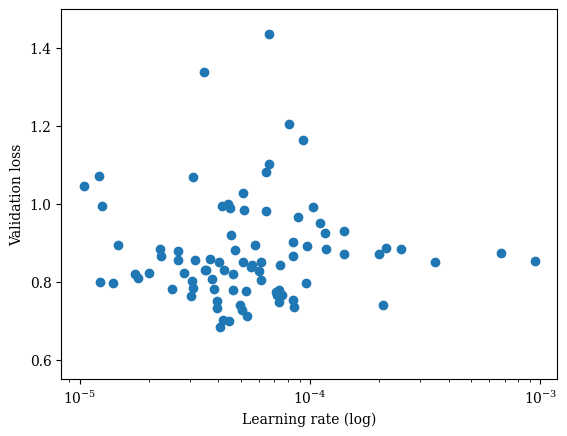

In [16]:
plt.scatter(df["config/learning_rate"], df["val_loss"])
plt.ylim(0.55, 1.5)
plt.ylabel("Validation loss")
plt.xlabel("Learning rate (log)")
plt.xscale("log")

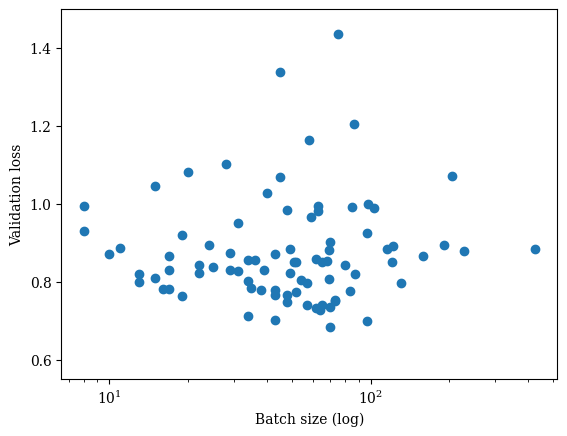

In [17]:
plt.scatter(df["config/batch_size"], df["val_loss"])
plt.ylim(0.55, 1.5)
plt.ylabel("Validation loss")
plt.xlabel("Batch size (log)")
plt.xscale("log")

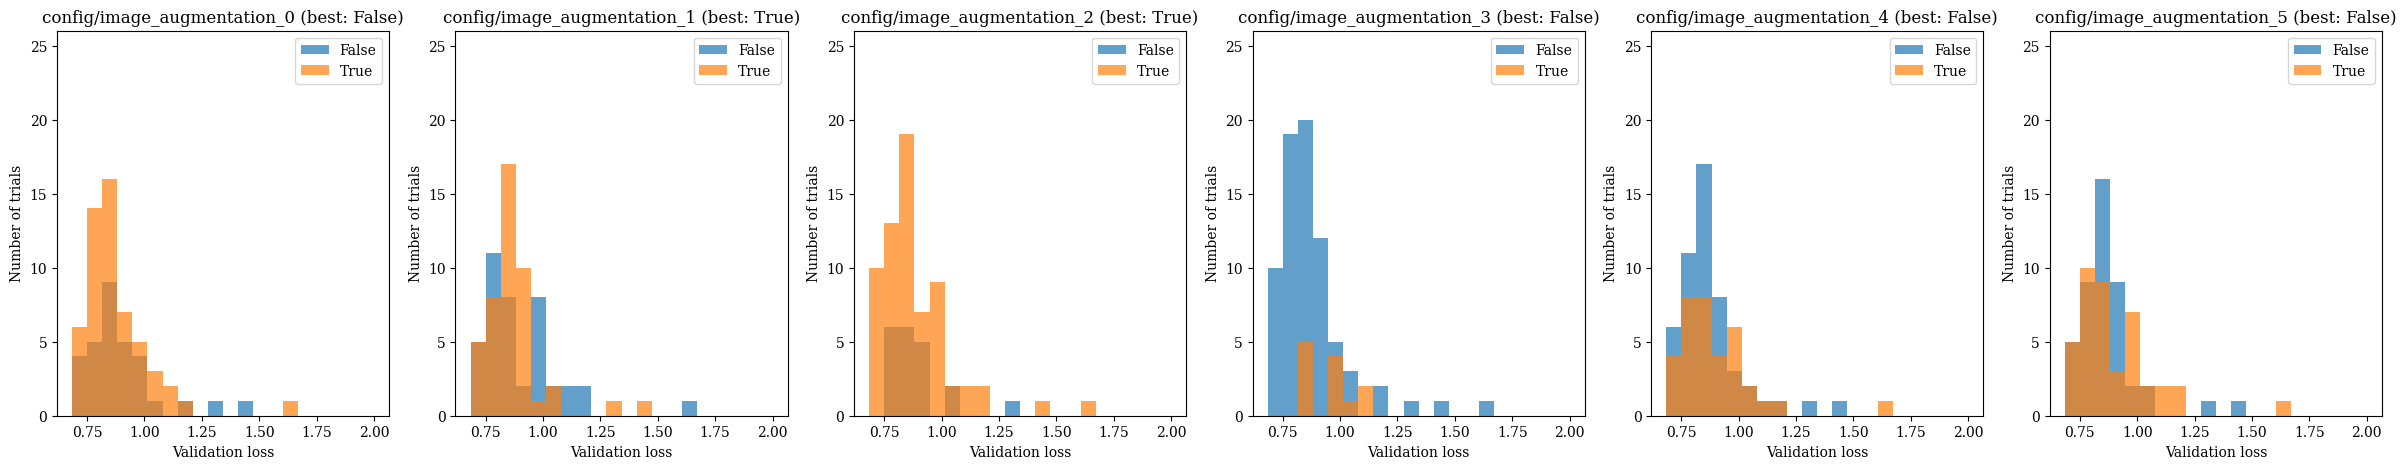

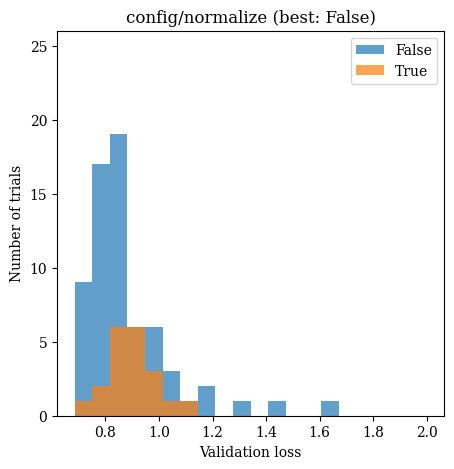

In [19]:
range_ = df["val_loss"].min(), 2


def plot_trials_binary_config(df, best, column_group):
    columns = [col for col in df.columns if column_group in col]

    _, ax_list = plt.subplots(1, len(columns), figsize=(5 * len(columns), 5))
    if len(columns) == 1:
        ax_list = [ax_list]

    for col, ax in zip(columns, ax_list):
        ax.set_title(f"{col} (best: {best[col]})")
        for value, group in df.groupby(col):
            ax.hist(
                group["val_loss"],
                label=value,
                range=range_,
                bins=20,
                alpha=0.7,
            )

        ax.set_xlabel("Validation loss")
        ax.set_ylabel("Number of trials")
        ax.legend()
        ax.set_ylim(0, 26)


plot_trials_binary_config(df, best, "config/image_augmentation")
# plot_trials_binary_config(df, best, "config/augmentation")
plot_trials_binary_config(df, best, "config/normalize")

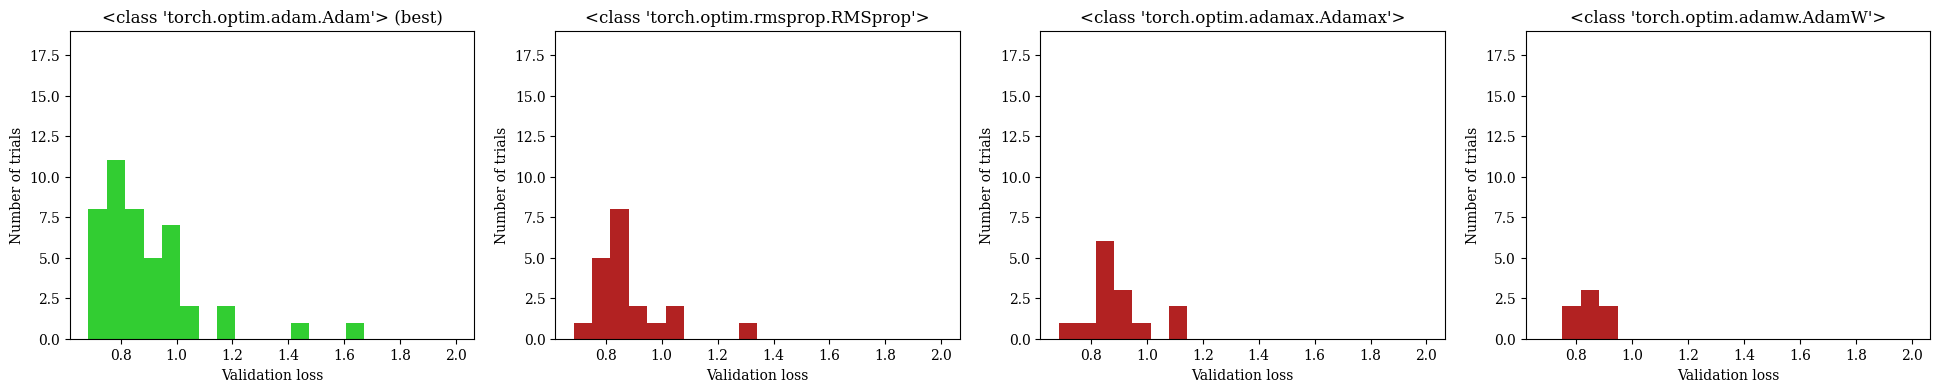

In [26]:
def plot_trials_multiple_config(column_group: str):
    nb_col = len(df[column_group].unique())
    _, ax_list = plt.subplots(1, nb_col, figsize=(6 * nb_col, 4))

    for ax, (value, group) in zip(
        ax_list, df.groupby(column_group, sort=False, dropna=False)
    ):
        title = f"{value}"
        color = "firebrick"
        if str(best[column_group]) == value:
            color = "limegreen"
            title += " (best)"

        ax.set_title(title)
        ax.hist(
            group["val_loss"],
            range=range_,
            bins=20,
            color=color,
        )
        ax.set_xlabel("Validation loss")
        ax.set_ylabel("Number of trials")
        ax.set_ylim(0, 19)


plot_trials_multiple_config("config/optimizer")
# plot_trials_multiple_config("config/color_jitter")  # Bug with color_jitter object